In [1]:
# --- Cell 1: Setup ---

using DifferentialEquations
using Flux
using Plots
using Optimization
using OptimizationOptimisers
using Zygote
using DataFrames

# Hodgkin-Huxley Model Parameters (Global Constants)
const Cm = 1.0        # μF/cm^2
const g_Na = 120.0    # mS/cm^2
const g_K = 36.0      # mS/cm^2
const g_L = 0.3       # mS/cm^2
const E_Na = 50.0     # mV
const E_K = -77.0     # mV
const E_L = -54.387   # mV

-54.387

In [2]:
# --- Cell 2: Known Physics & Stimulus ---

# Voltage-gated ion channel kinetics
α_n(V) = 0.01 * (V + 55) / (1 - exp(-(V + 55) / 10))
β_n(V) = 0.125 * exp(-(V + 65) / 80)
α_m(V) = 0.1 * (V + 40) / (1 - exp(-(V + 40) / 10))
β_m(V) = 4.0 * exp(-(V + 65) / 18)
α_h(V) = 0.07 * exp(-(V + 65) / 20)
β_h(V) = 1 / (1 + exp(-(V + 35) / 10))

# Steady-state & time-constant functions for the 2D model
m_inf(V) = α_m(V) / (α_m(V) + β_m(V))
h_inf(V) = α_h(V) / (α_h(V) + β_h(V))
n_inf(V) = α_n(V) / (α_n(V) + β_n(V))
tau_n(V) = 1 / (α_n(V) + β_n(V))

# Stimulus protocol: a short, sharp pulse
function stimulus(t; start=10.0, duration=1.0, amplitude=20.0)
    (start <= t < start + duration) ? amplitude : 0.0
end

stimulus (generic function with 1 method)

In [3]:
# ---- Hyperparameters / safety ----
nn_scale = 0.01           # scale factor for NN output (tune: 1e-3 .. 1e-1)
abstol = 1e-8
reltol = 1e-6
maxsteps = 1e7            # optional large step cap
grad_clip_norm = 5.0      # clip gradient L2 norm to this value
lr = 0.01                 # learning rate for Adam
num_iters = 1000          # training iterations (or use your callback loop)

1000

In [4]:
# --- Cell 3: Data Generation ---

# 2D Hodgkin-Huxley reduced model engine
function hodgkin_huxley_reduced!(du, u, p, t)
    V, n = u
    I_ext = stimulus(t)
    I_Na = g_Na * m_inf(V)^3 * h_inf(V) * (V - E_Na)
    I_K  = g_K  * n^4 * (V - E_K)
    I_L  = g_L * (V - E_L)
    du[1] = (I_ext - I_Na - I_K - I_L) / Cm
    du[2] = (n_inf(V) - n) / tau_n(V)
end

# Define and solve the 2D problem to generate training data
u₀_reduced = Float64[-65.0, 0.3177]
tspan_reduced = (Float64(0.0), Float64(50.0))
prob_reduced = ODEProblem(hodgkin_huxley_reduced!, u₀_reduced, tspan_reduced, nothing)
sol_reduced = solve(prob_reduced, Tsit5(), saveat=0.1)

# Extract and structure the training data
 training_data_2D = Array(sol_reduced)
 timestamps_2D = Float64.(sol_reduced.t)

# (Optional) Verify data shape and content
df = DataFrame(t=timestamps_2D, V=training_data_2D[1, :], n=training_data_2D[2, :])
println("Generated Training Data:")
display(first(df, 5))

Generated Training Data:


Row,t,V,n
,Float64,Float64,Float64
1,0.0,-65.0,0.3177
2,0.1,-64.9997,0.3177
3,0.2,-64.9994,0.317699
4,0.3,-64.9991,0.317699
5,0.4,-64.9989,0.317699


In [43]:
# explicitly defining weights and biases to Float64
W1= randn(Float64, 10 ,1)
b1=zeros(Float64,10)
W2=randn(Float64,1,10)
b2=zeros(Float64,1)

# Creating the layer using provided Float64 arrays
layer1 = Dense(W1,b1, tanh)
layer2 = Dense(W2,b2)
# Define the Neural Network structure
 U = Chain(layer1,layer2)

# Extract the trainable parameters (p_nn) and the re-structuring function (re)
p_nn, re = Flux.destructure(U)

# Define the UDE function with the embedded neural network
function ude_model!(du, u, p_nn, t)
    V, n = u
    
    # Neural network component to learn the unknown current
    unknown_current = 0.01 * re(p_nn)([V])[1]


    
    # Known physics components
    I_ext = stimulus(t)
    I_K  = g_K  * n^4 * (V - E_K)
    I_L  = g_L * (V - E_L)
    
    # The hybrid dynamics equation
    du[1] = (I_ext + unknown_current - I_K - I_L) / Cm
    du[2] = (n_inf(V) - n) / tau_n(V)
end

ude_model! (generic function with 1 method)

In [44]:
# check parameter element types
println("Parameter element types:")
for param in Flux.params(U)
    println(eltype(param), " size=", size(param))
end

# quick forward check
test_in = Float64[-65.0]
println("NN forward:", re(p_nn)(test_in))


Parameter element types:
Float64 size=(10, 1)
Float64 size=(10,)
Float64 size=(1, 10)
Float64 size=(1,)
NN forward:[-0.031753459792357]


In [45]:
using SciMLSensitivity
using DifferentialEquations
using SciMLSensitivity   # or DiffEqSensitivity if you prefer
using Zygote
using Optimisers         # for optimizer & update
using LinearAlgebra

In [46]:
# ---- Stable predict function using BacksolveAdjoint and Float64 inputs ----
function predict_ude(p_nn)
    # build problem with the current flattened NN params
    prob_ude = ODEProblem(ude_model!, u₀_reduced, tspan_reduced, p_nn)
    # Use BacksolveAdjoint for stable gradients
    sol = solve(prob_ude, Tsit5(),
                saveat = timestamps_2D,
                abstol = abstol, reltol = reltol,
                maxiters = maxsteps,
                sensealg = BacksolveAdjoint(autojacvec = true))
    return sol
end

# ---- Loss function (keep as Float64) ----
function loss_function(p_nn)
    sol = predict_ude(p_nn)
    if sol.retcode != :Success
        return Inf
    end
    # squared error (Float64)
    return sum(abs2, Array(sol) .- training_data_2D)
end

loss_function (generic function with 1 method)

In [47]:
# --- Cell 6: Training ---

# Callback function to display progress during training
losses = Float64[]
iter = 0
callback = function (p, l)
    global iter += 1
    push!(losses, l)
    if iter % 200 == 0
        println("Iteration $iter | Current Loss: $l")
    end
    return false # Must return false to continue training
end

# Define the optimization problem
optf = Optimization.OptimizationFunction((x, p) -> loss_function(x), Optimization.AutoZygote())
optprob = Optimization.OptimizationProblem(optf, p_nn)

# Execute the training mission
println("Commencing Training...")
# We use a lower learning rate for stability and more iterations.
# This is a full-scale training run. It may take a few minutes.
result_ude = Optimization.solve(optprob, Adam(0.01), callback = callback, maxiters = 5000)

println("--- TRAINING COMPLETE ---")
println("Final Loss: $(result_ude.objective)")

Commencing Training...
Iteration 10 | Current Loss: 2125.3165754994893
Iteration 20 | Current Loss: 2110.1308982041865
Iteration 30 | Current Loss: 2102.475334881656
Iteration 40 | Current Loss: 2097.6040653377036
Iteration 50 | Current Loss: 2088.692358309934
Iteration 60 | Current Loss: 2083.092211591866
Iteration 70 | Current Loss: 2074.7401554387548
Iteration 80 | Current Loss: 2068.0862277415267
Iteration 90 | Current Loss: 2061.353460946616
Iteration 100 | Current Loss: 2055.2873546823917
Iteration 110 | Current Loss: 2047.6384193743315
Iteration 120 | Current Loss: 2043.0052670410398
Iteration 130 | Current Loss: 2034.5720761303016
Iteration 140 | Current Loss: 2029.9807366825778
Iteration 150 | Current Loss: 2023.6578308874828
Iteration 160 | Current Loss: 2017.3648747241841
Iteration 170 | Current Loss: 2012.2364359680066
Iteration 180 | Current Loss: 2004.9535693774467
Iteration 190 | Current Loss: 1999.987088598675
Iteration 200 | Current Loss: 1994.520075339332
Iteration 21

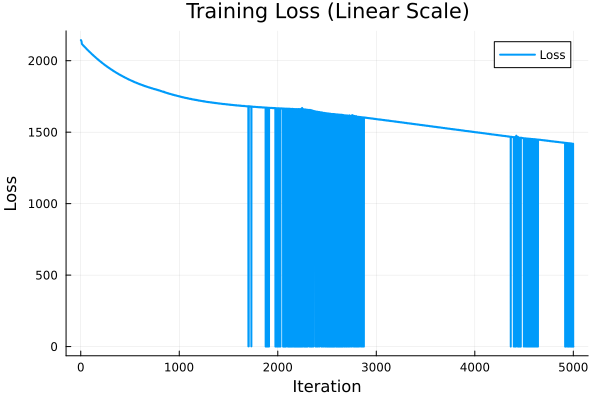

In [48]:
plot(losses,
     xlabel="Iteration",
     ylabel="Loss",
     title="Training Loss (Linear Scale)",
     label="Loss",
     lw=2)


In [49]:

if isempty(losses)
    @warn "No losses recorded — run training first."
else
    window = 20
    smooth_losses = [ mean(losses[max(1, i-window):i]) for i in 1:length(losses) ]
    plot(smooth_losses,
         xlabel="Iteration",
         ylabel="Smoothed Loss",
         title="Smoothed Training Loss",
         lw=2)
end


UndefVarError: UndefVarError: `mean` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Statistics in the current active module Main
Hint: a global variable of this name may be made accessible by importing StatsBase in the current active module Main
Hint: a global variable of this name may be made accessible by importing Distributions in the current active module Main